# Monte Carlo Withdrawal Simulation

Analyze the success of withdrawal strategies using Monte Carlo simulations.
 
To try different scenarios, simply change the assumptions in the last cell.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import List

In [2]:
@dataclass
class Config:
    annual_inflation_rate: float
    expected_annual_return: float
    expected_annual_volatility: float
    num_simulations: int
    withdrawal_rate: float
    years: int

In [3]:
def run_simulation(config: Config):
    returns = np.random.normal(
        loc=config.expected_annual_return,
        scale=config.expected_annual_volatility,
        size=config.years,
    )

    withdrawals = np.array(
        [
            config.withdrawal_rate * (1 + config.annual_inflation_rate) ** year
            for year in range(config.years)
        ]
    )

    balances = np.zeros(config.years + 1)
    balances[0] = 1

    for i in range(1, config.years + 1):
        balances[i] = (balances[i - 1] - withdrawals[i - 1]) * (1 + returns[i - 1])
        if balances[i] < 0:
            balances[i:] = balances[i]
            break

    return balances


def run_simulations(config: Config):
    all_balances: List[np.ndarray] = []
    for i in range(config.num_simulations):
        balances = run_simulation(config)
        all_balances.append(balances)

    return np.array(all_balances)

In [4]:
def run(config: Config):
    all_balances_list = run_simulations(config=config)
    all_balances = np.array(all_balances_list)

    final_balances = all_balances[:, -1]

    # Stats
    stats = {
        "Failure Rate (%)": np.mean(final_balances <= 0) * 100,
        "5th Percentile": np.percentile(final_balances, 5),
        "25th Percentile": np.percentile(final_balances, 25),
        "50th Percentile (Median)": np.percentile(final_balances, 50),
        "75th Percentile": np.percentile(final_balances, 75),
        "95th Percentile": np.percentile(final_balances, 95),
        "Min": final_balances.min(),
        "Mean": np.mean(final_balances),
        "Max": final_balances.max(),
    }

    print(f"{'Statistic':<25} {'Value':>15}")
    print("-" * 40)
    for key, value in stats.items():
        print(f"{key:<25} {value:>15,.2f}")

    x = np.arange(config.years + 1)
    mean_balance = all_balances.mean(axis=0)
    percentiles = np.percentile(all_balances, [5, 25, 50, 75, 95], axis=0)

    plt.figure(figsize=(12, 6))

    plt.fill_between(x, percentiles[0], percentiles[4], color="gray", alpha=0.3, label="5th-95th percentile")
    plt.fill_between(x, percentiles[1], percentiles[3], color="blue", alpha=0.2, label="25th-75th percentile")

    plt.plot(x, mean_balance, color="blue", linewidth=2, label="Mean")
    plt.plot(x, percentiles[2], color="green", linestyle="--", linewidth=2, label="Median")

    plt.xlabel("Year")
    plt.ylabel("Balance")
    plt.title(f"Balance projections over {config.years} years ({config.num_simulations:,} simulations)\nStarting balance = 1")
    plt.grid(True)
    plt.legend()
    plt.show()


Statistic                           Value
----------------------------------------
Failure Rate (%)                    16.80
5th Percentile                      -0.04
25th Percentile                      0.62
50th Percentile (Median)             2.97
75th Percentile                      6.82
95th Percentile                     18.58
Min                                 -0.07
Mean                                 5.21
Max                                 55.16


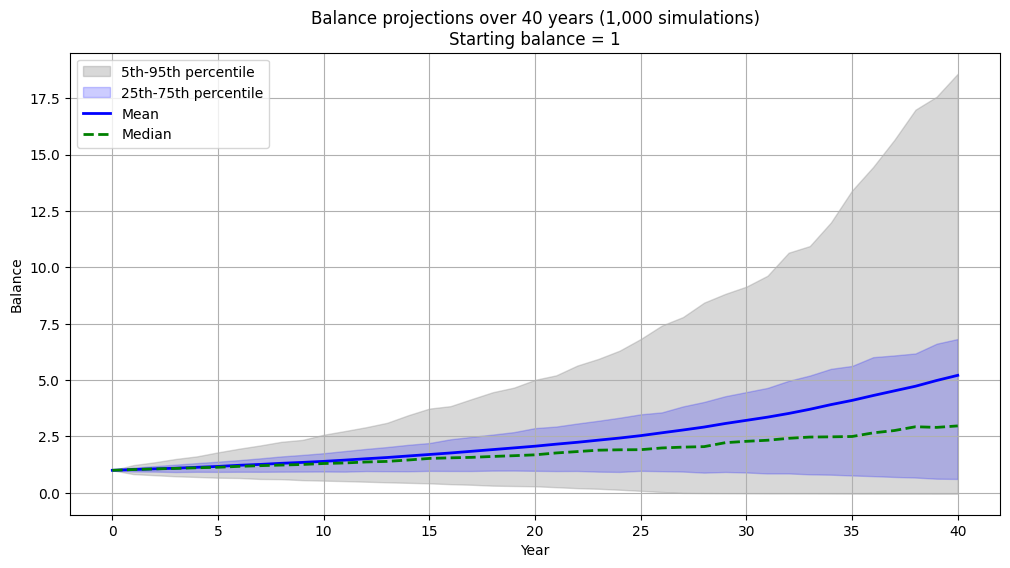

In [5]:
config = Config(
    annual_inflation_rate=0.021,
    expected_annual_return=0.065,
    expected_annual_volatility=0.13,
    num_simulations=1_000,
    withdrawal_rate=0.03,
    years=40,
)

run(config)